<IPython.core.display.Javascript object>


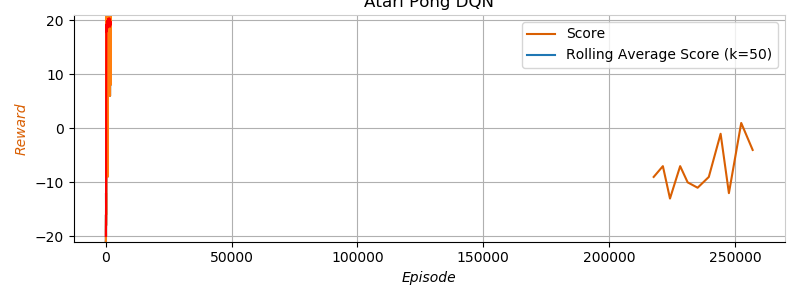

In [10]:
%matplotlib notebook
import tensorwatch as tw
import time

# streams will be stored in test.log file
client = tw.WatcherClient()

# create a stream for logging
stream = client.create_stream(expr='lambda d: (d.frames, d.episode_score)')

line_plot = tw.Visualizer(stream, vis_type='line', xtitle="Frames", ytitle="Reward", yrange=(-21,21))
line_plot.show()

In [26]:
avg_stream = client.create_stream(expr='lambda d:(d.frames, d.total_score/d.episode)')
avg_plot = tw.Visualizer(avg_stream, vis_type='line', host=line_plot, xtitle='Frames', ytitle='Average Reward', yrange=(-21,21))
avg_plot.show()

In [ ]:
from models import Qnet
q = Qnet(84,84,4,4)
tw.model_stats(q,[1,4,84,84])

In [1]:
import pandas as pd
from matplotlib import pyplot as plt

def convert_line_to_dict(line):
    out_dict = {}
    lines = [l.strip() for l in line.strip().split(',')]
    for kv in lines:
        k,v = kv.split(':')
        k=k.strip()
        v=v.strip()
        out_dict[k] = float(v.replace('%',''))
    return out_dict

def load_stats_from_logging(logging_file):
    with open(logging_file,'r') as f:
        lines = f.readlines()
    dicts = [convert_line_to_dict(line) for line in lines]
    return pd.DataFrame(dicts)


def load_multiple_models(model_log_files):
    return [load_stats_from_logging(log_file) for log_file in model_log_files]

In [2]:
def plot_x_vs_y(x, y, xlab, ylab, models, legend, episode_start = 0, episode_end = None):
    plt.figure(figsize=(20,10))
    
    for m in models:
        plt.plot(m.iloc[episode_start:episode_end][x], m.iloc[episode_start:episode_end][y])
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title("Atari Pong")
    plt.legend(legend)
    plt.show()
def plot_episode_vs_reward(models, model_legend, episode_start = 0, episode_end=None):
    plot_x_vs_y('n_episode', 'Episode Score', 'Episode', 'Reward', models, model_legend, episode_start, episode_end)
    
def plot_episode_vs_reward_rolling(models, model_legend, episode_start = 0, episode_end=None, k=1):
    models = [m.rolling(k).mean() for m in models]
    plot_episode_vs_reward(models, model_legend, episode_start, episode_end)

def plot_frames_vs_reward(models, model_legend, episode_start = 0, episode_end=None):
    plot_x_vs_y('Total Frames', 'Episode Score', 'Frames', 'Reward', models, model_legend, episode_start, episode_end)
    
def plot_frames_vs_reward_rolling(models, model_legend, episode_start = 0, episode_end=None, k=1):
    models = [m.rolling(k).mean() for m in models]
    plot_frames_vs_reward(models, model_legend, episode_start, episode_end)

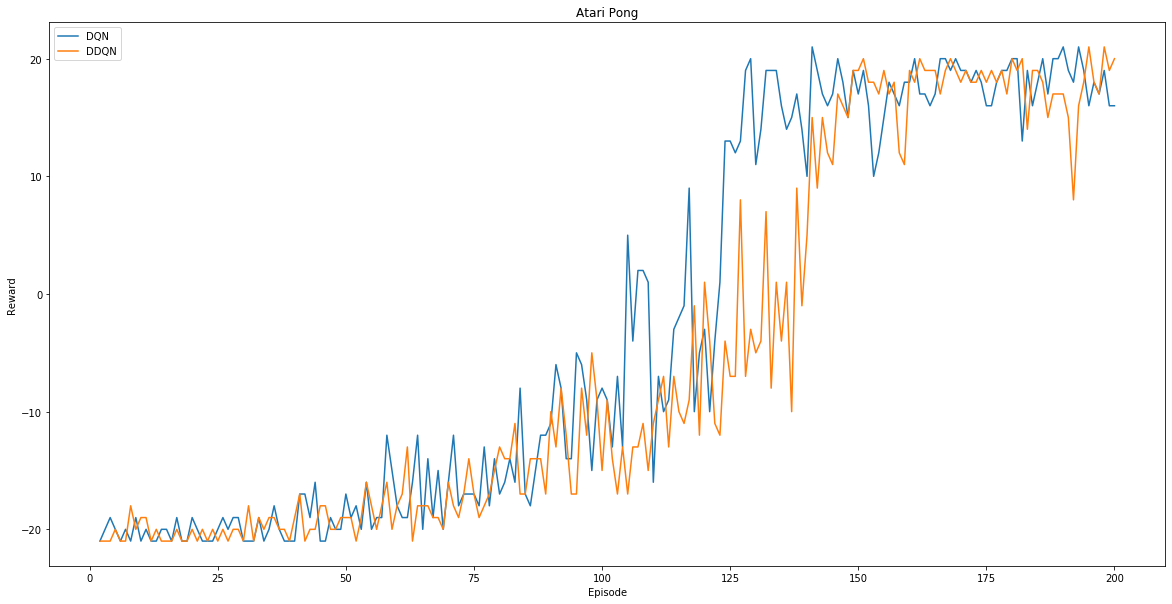

In [3]:
legend = ['DQN', 'DDQN']
models = ['log/dqn.out', 'log/ddqn.out']
dfs = load_multiple_models(models)
plot_episode_vs_reward(dfs, legend, 1, 200)

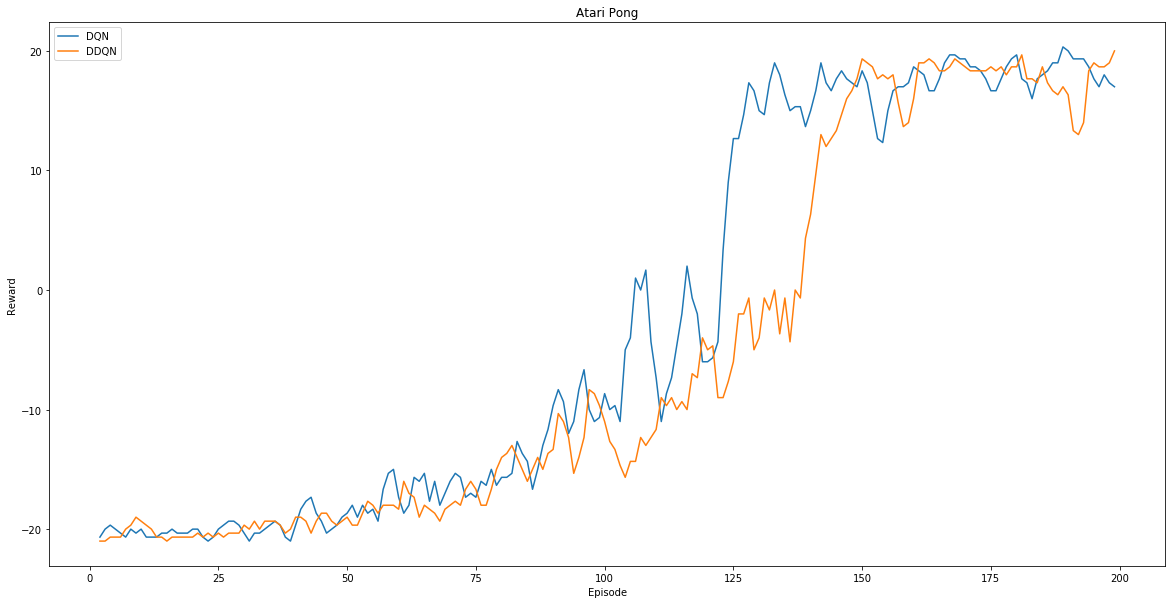

In [4]:
plot_episode_vs_reward_rolling(dfs, legend, 1, 200, 3)

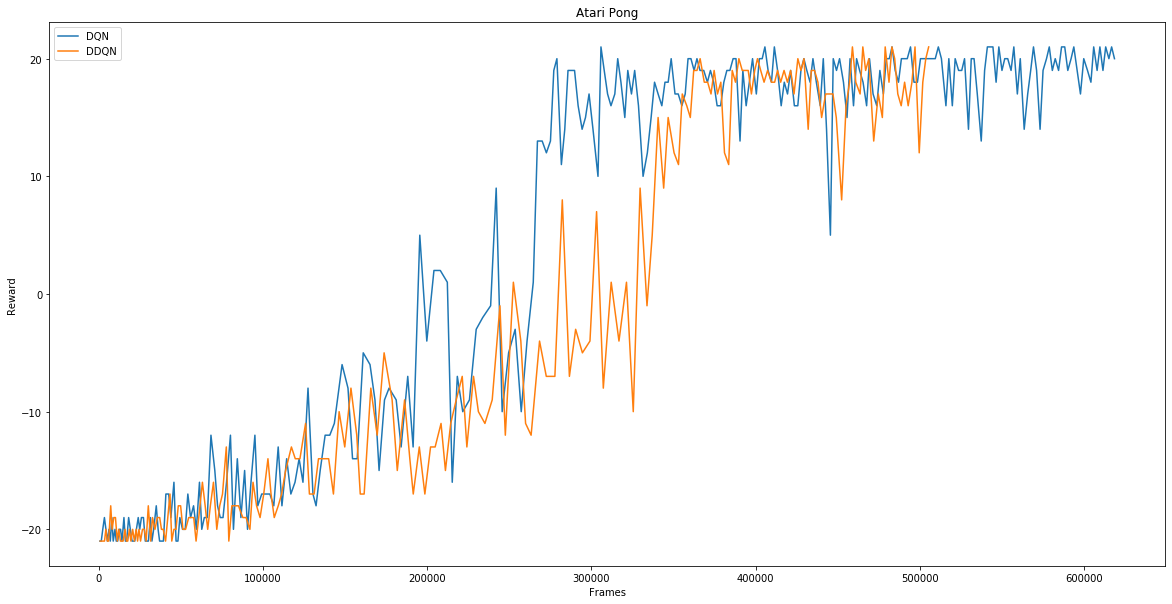

In [9]:
plot_frames_vs_reward(dfs, legend, 0, 300)

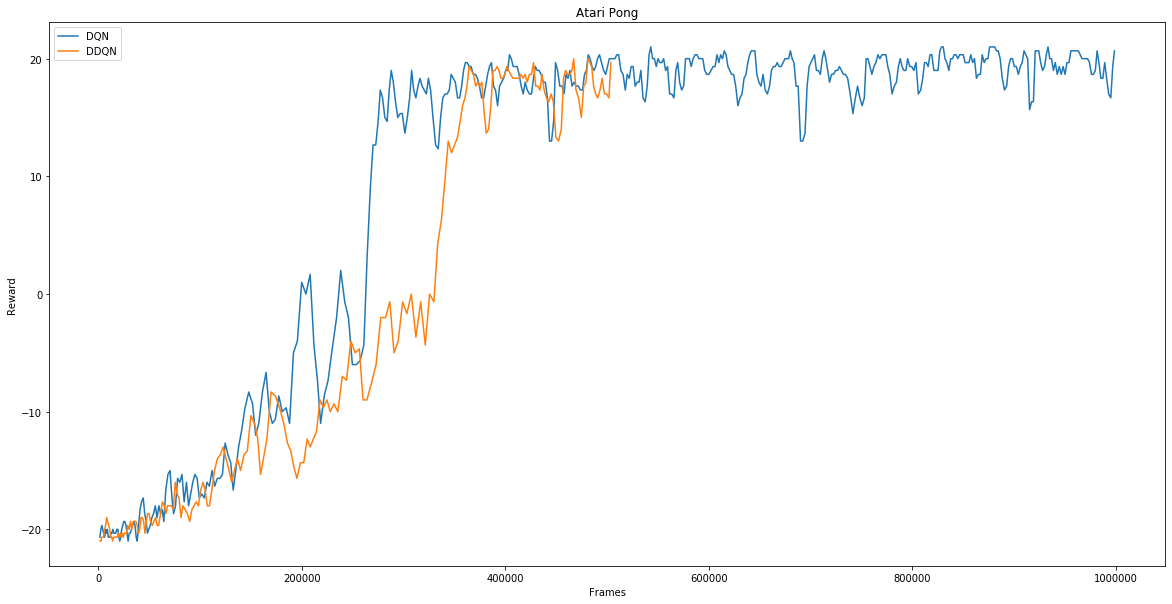

In [7]:
plot_frames_vs_reward_rolling(dfs, legend, 0, 500, 3)

In [10]:
rolling_df = df.rolling(50).mean()
plt.figure(figsize=(20,10))
plt.plot(df['n_episode'], df['Episode Score'])
#plt.plot(df['Total Frames'], df['Average Score'])
plt.plot(rolling_df['n_episode'], rolling_df['Episode Score'], color='red')
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Atari Pong")
plt.legend(['Score', 'Rolling Average Score (k=50)'])
plt.show()

NameError: name 'df' is not defined